In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from scipy.optimize import minimize, approx_fprime

In [2]:
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 1000
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True 
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [3]:
G = 6.67259e-8 # dyne cm2 g-2
c = 2.998e10 # cms-1
n_den = 2.3e14
# G = c = 1

def lamba_metric(M, R):
    return -0.5*np.log((1-2*G*M/(c**2*R)))

In [54]:
# Working in manual cgs units here. 

# DIMENSIONS CHECKED
def _dMdr(r, e):
    return 4 * np.pi * r**2 * (e/(c**2))

# DIMENSIONS CHECKED
def _dPhidr(r, P, M):
    factor1 = G/(c**2) 
    num = (M+4*np.pi*(r**3)*P/(c**2))
    dem = r * (r-2*G*M/(c**2))
    return factor1*num/dem

# DIMENSIONS CHECKED
def _dPdr(r, P, M, e):
    factor2 = -1 # factor goes in dphi/dr
    term1 = (e+P) 
    dphidr = _dPhidr(r, P, M)
    return factor2 * term1 * dphidr

# DIMENSIONS CHECKED
def _dWdr(r, V, W, phi, dphidr, dedp, omega, lamda, l):
    term1 = (omega**2) * (r**2) * np.exp(lamda - 2*phi)*V * (1/(c**2))
    term2 = dphidr * W
    brackets = term1 + term2
    ret = dedp * brackets - l*(l+1)*np.exp(lamda)*V
    return ret

# DIMENSIONS CHECKED
def _dVdr(r, V, W, dphidr, lamda):
    return 2*dphidr*V - np.exp(lamda)*(W/(r**2))

def coupledTOV(r, VEC, init_params):
    P, M, phi, W, V = VEC
    EOS, l, omega = init_params
    lamda = lamba_metric(M, r)
    
    e = EOS(P)
#     cs = 1
#     dedp = 1/(cs**2) 

    eps = 1e-4
    p_eval = np.linspace(P*(1-eps), P*(1+eps), 10)
    e_eval = EOS(p_eval)
    dedp = np.mean(np.gradient(e_eval, p_eval, edge_order=2))

#     dedp = approx_fprime(P, EOS, epsilon = eps)

    #Ideally you need to remove this once you fixed w, v plots. 
    dedp = min(dedp, 100) # UNPHYSICAL BUT USED TO SATISFY BAD BOUNDARY BEHAVIOUR
    
    
    dPdr = _dPdr(r, P, M, e)
    dMdr = _dMdr(r, e)
    dPhidr = _dPhidr(r, P, M)
    dWdr = _dWdr(r, V, W, phi, dPhidr, dedp, omega, lamda, l)
    dVdr = _dVdr(r, W, W, dPhidr, lamda)
    ret = [dPdr, dMdr, dPhidr, dWdr, dVdr]
    return ret

In [55]:
def df_to_ep(df):
    n_den = 2.3e14
    e_den = df.energy_densityc2
    e_den_normed = e_den#/n_den
    p = df.pressurec2
    e_den_normed = e_den_normed*(c**2)
    pressure = p*(c**2)
    return e_den_normed.to_numpy(), pressure.to_numpy()

def get_ep(e, p):
    f_e_smooth = interp1d(p, e, fill_value="extrapolate")
    return f_e_smooth

In [56]:
##### Sanity check that my gradient is working. 

In [57]:
# df = pd.read_csv("eos_data/sly230a.csv")
# e, p = df_to_ep(df)
# EOS = get_ep(e, p)
# plt.plot(p, e)
# plt.figure()
# dedp = np.zeros(len(p))
# dedp2 = np.zeros(len(p))
# for i in tqdm(range(len(p))):
#     eps = 1e-4
#     p_eval = np.linspace(p[i]*(1-eps), p[i]*(1), 10)
#     e_eval = EOS(p_eval)
# #     print(np.gradient(e_eval), edge_order=2)
#     dedp[i] = np.gradient(e_eval, p_eval)[0]
#     dedp2[i] = approx_fprime(np.mean(p_eval), EOS, epsilon = eps)

# plt.plot(p, dedp, linestyle = "dashed")
# plt.plot(p, dedp2)
# plt.xlim(0, 1e36)
# plt.ylim(0, 10)

In [58]:
def tov(ep, init_VEC, r_i, p_min, omega, progress = False, 
        l=2):
    
    init_params = [ep, l, omega]

    r = ode(lambda r, VEC: coupledTOV(r, VEC, init_params)).set_integrator('LSODA')
    r.set_initial_value(init_VEC, r_i)

    results = []
    r_list = []

    i = 0
    r_max = 20 * km2cm
    # max_iter = 1000000 # Change back to this if "Excess work done on this call" error. 
    max_iter = 2000

    dr_init = r_max/max_iter
    dr_compute = 1000
    
    if progress:
        pbar = tqdm(total=max_iter)

    while r.successful() and (r.y[0] >= p_min):
        i+=1

        dr = min(dr_init, dr_compute)

        integral = r.integrate(r.t+dr)
        
        results.append(integral)
        r_list.append(r.t+dr_init)

    #     dr_compute = r * dP /P 

        if progress:
            pbar.update(1)
        if i > max_iter:
            print("[STATUS] max_iter reached")
            break
    
    if progress:
        pbar.close()
        
#     print(r.successful() , (r.y[0] > p_min))
    
    results = np.array(results, dtype = float)
    p, m, phi, w, v = results.T
    r = np.array(r_list)
    return p, m, r, phi, w, v

In [59]:
# Load EOS
df = pd.read_csv("eos_data/sly230a.csv")
e, p = df_to_ep(df)
EOS = get_ep(e, p)

# Initial Conditions
km2cm = 1e5
r_i = 1
p0 = p[-5]
e0 = EOS(p0)
p_c = p0 - 2 * np.pi * (G/(c**4)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
e_c = e0
m0 = e_c/(c**2) * 4/3 * np.pi * r_i**3

phi0 = -1 #Arbitrary guess 
omega = 1e3 #Arbitrary guess

C = 1 # Arbitrary constant
l = 2
W0 =  C   * r_i ** (l+1)
V0 = -C/l * r_i ** (l)

init_VEC = [p_c, m0, phi0, W0, V0]
msun = 2e33
p_min = min(p)

M_guess = 1.5 * msun
R_guess = 10 * km2cm

# Integrate
p, m, r_arr, phi, w, v = tov(EOS, init_VEC, r_i, p_min, omega,progress = True, l = l)

max_idx = np.argmax(m)
m_R = m.max() # In units of msun
r_R = r_arr[max_idx] # In units of km
p_R = p[max_idx] #cgs
ec_R = EOS(p_R) #cgs
phi_R = phi[max_idx] #cgs
v_R = v[max_idx]
w_R = w[max_idx]

schild = (1-2*G*m_R/(c**2*r_R))
interior = np.exp(2*phi[-1])

# Log base e
phi_ext = 0.5 * np.log(schild) #At surface
phi_int = phi[-1] #At surface


# DIMENSIONED CHECKED
def boundary_wv(r_R, p_R, m_R, omega, phi_int, v_R):
    dPhidr_R = _dPhidr(r_R, p_R, m_R)
    lamda = lamba_metric(m_R, r_R)
    term1 = (1/(c**2))*(omega**2 * r_R**2)*np.exp(lamda-2*phi_int)*v_R
    term2 = dPhidr_R * w_R
    return term1 + term2


print("== First Integration == ")
print(f"Star has mass {m_R/msun:.1f} Msun and radius {r_R/km2cm:.1f}km")
print(f"Interior Surface: {interior:.4f}")
print(f"Exterior Surface: {schild:.4f}")
print(f"Phi0 Round 1: {phi0}")
print(f"Lamda Round 1: {lamba_metric(m_R, r_R)}")
print(f"Boundary Term: {boundary_wv(r_R, p_R, m_R, omega, phi_int, v_R)}")

# Computer new phi0
delta_phi = phi_int - phi_ext
phi0 =  phi0 - delta_phi

# Repeated Integration
C = 1 # Arbitrary constant

W0 =  C   * r_i ** (l+1)
V0 = -C/l * r_i ** (l)

init_VEC = [p_c, m0, phi0, W0, V0]
msun = 2e33
p_min = min(p)
M_guess = m_R
R_guess = r_R
time.sleep(0.2)

# Integrate
p, m, r_arr, phi, w, v = tov(EOS, init_VEC, r_i, p_min, omega, progress = True, l = l)

max_idx = np.argmax(m)
m_R = m.max() # In units of msun
r_R = r_arr[max_idx] # In units of km
p_R = p[max_idx] #cgs
ec_R = EOS(p_R) #cgs
phi_R = phi[max_idx] #cgs

schild = (1-2*G*m_R/(c**2*r_R))
interior = np.exp(2*phi[-1])

phi_ext = 0.5 * np.log(schild) #At surface
phi_int = phi[-1] #At surface

print("== Repeated Integration == ")
print(f"Star has mass {m_R/msun:.1f} Msun and radius {r_R/km2cm:.1f}km")
print(f"Interior Surface: {interior:.4f}")
print(f"Exterior Surface: {schild:.4f}")
print(f"Phi0 Round 2: {phi0}")
print(f"Lamda Round 2: {lamba_metric(m_R, r_R)}")
print(f"Boundary Term: {boundary_wv(r_R, p_R, m_R, omega, phi_int, v_R)}")

 49%|████▉     | 989/2000 [00:18<00:25, 39.57it/s] /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1350: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
 50%|████▉     | 992/2000 [00:19<00:19, 51.97it/s]


== First Integration == 
Star has mass 2.1 Msun and radius 9.9km
Interior Surface: 0.7798
Exterior Surface: 0.3789
Phi0 Round 1: -1
Lamda Round 1: 0.48530247497484036
Boundary Term: 1581152.225441384


 50%|████▉     | 992/2000 [00:18<00:19, 52.49it/s] 

== Repeated Integration == 
Star has mass 2.1 Msun and radius 9.9km
Interior Surface: 0.3789
Exterior Surface: 0.3789
Phi0 Round 2: -1.3609383619219724
Lamda Round 2: 0.4853020221075884
Boundary Term: 2338438.1702792123


Boundary term changes since $\Phi_{int}(R)$ changes. 

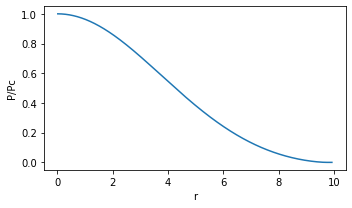

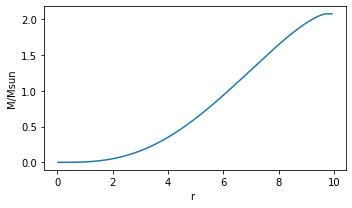

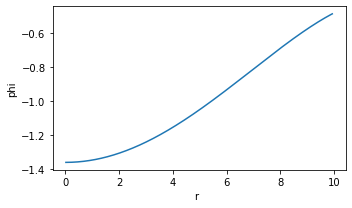

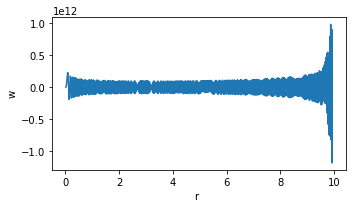

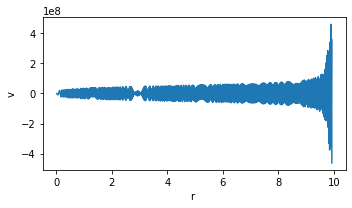

In [60]:
r_arr = r_arr/km2cm

plt.figure()
plt.plot(r_arr, p/p_c)
plt.xlabel("r")
plt.ylabel("P/Pc")

plt.figure()
plt.plot(r_arr, m/msun)
plt.xlabel("r ")
plt.ylabel("M/Msun")
plt.show()

plt.figure()
plt.plot(r_arr, phi)
plt.xlabel("r ")
plt.ylabel("phi")
plt.show()

plt.figure()
plt.plot(r_arr, w)
plt.xlabel("r ")
plt.ylabel("w")
plt.show()

plt.figure()
plt.plot(r_arr, v)
plt.xlabel("r ")
plt.ylabel("v")
plt.show()

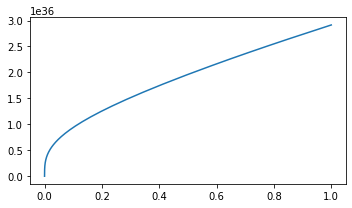

In [61]:
plt.plot(p/p_c, EOS(p))

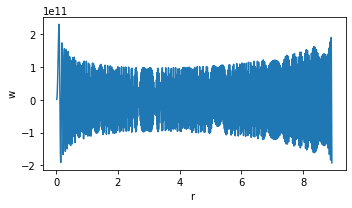

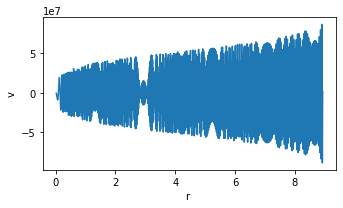

In [62]:
plt.figure()
plt.plot(r_arr[:int(0.9*len(r_arr))], w[:int(0.9*len(r_arr))])
plt.xlabel("r ")
plt.ylabel("w")
plt.show()

plt.figure()
plt.plot(r_arr[:int(0.9*len(r_arr))], v[:int(0.9*len(r_arr))])
plt.xlabel("r ")
plt.ylabel("v")
plt.show()

In [12]:
# # Delete when shifting over to python
# old_backend = mpl.get_backend() 
# %matplotlib notebook 
# # ====================================================================================
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.ion()
# fig.show()
# fig.canvas.draw()
# plt.xlabel("f-mode (omega)")
# plt.ylabel("boundary value")

# def minimize_boundary(omega, p = p, EOS = EOS):
#     # Repeat integration
#     C = 1 # Arbitrary constant

#     W0 =  C   * r_i ** (l+1)
#     V0 = -C/l * r_i ** (l)

#     init_VEC = [p_c, m0, phi0, W0, V0]
#     msun = 2e33
#     p_min = min(p)
#     M_guess = m_R
#     R_guess = r_R

#     # Integrate
#     p, m, r_arr, phi, w, v = tov(EOS, init_VEC, r_i, p_min, omega, progress = False, 
#                                  l = l)

#     loss = abs(boundary_wv(r_R, p_R, m_R, omega, phi_int, v_R))
#     ax.scatter(omega/(2*np.pi), loss, color = "dodgerblue", marker = "x")
#     fig.canvas.draw()
#     return loss

# omega_guess = 1e3
# res = minimize(minimize_boundary, x0 = omega_guess, method='Nelder-Mead', 
#                options = {"disp": True, "maxiter":5, "bounds":[(0, omega_guess * 100)]},
#                tol = 1e1)

# mpl.use(old_backend) # Delete when shifting over to python

In [13]:
# print(p0)
# print(f"f-mode: {res.x[0]}")
# lamda = lamba_metric(M_guess, R_guess)
# omega_theory = np.sqrt((-_dPhidr(r_R, p_R, m_R)*w_R)/(r_R**2 * np.exp(lamda - 2*phi_int)*v_R))
# print(f"theory: {omega_theory}")

# omega = omega_theory
# dPhidr_R = _dPhidr(r_R, p_R, m_R)
# term1 = (1/(c**2))*(omega**2 * r_R**2)*np.exp(lamda-2*phi_int)*v_R
# term2 = dPhidr_R * w_R
# boundary = term1 + term2
# # display(term1, term2, boundary)

In [14]:
# # Final Integration
# omega = res.x[0]
# C = 1 # Arbitrary constant

# W0 =  C   * r_i ** (l+1)
# V0 = -C/l * r_i ** (l)

# init_VEC = [p_c, m0, phi0, W0, V0]
# msun = 2e33
# p_min = min(p)
# M_guess = m_R
# R_guess = r_R
# time.sleep(0.2)

# # Integrate
# p, m, r_arr, phi, w, v = tov(EOS, init_VEC, r_i, p_min, omega, progress = True, l = l)

# max_idx = np.argmax(m)
# m_R = m.max() # In units of msun
# r_R = r_arr[max_idx] # In units of km
# p_R = p[max_idx] #cgs
# ec_R = EOS(p_R) #cgs
# phi_R = phi[max_idx] #cgs

# schild = (1-2*G*m_R/(c**2*r_R))
# interior = np.exp(2*phi[-1])

# print("== Final Integration == ")
# print(f"Star has mass {m_R/msun:.1f} Msun and radius {r_R/km2cm:.1f}km")
# print(f"Interior Surface: {interior:.4f}")
# print(f"Exterior Surface: {schild:.4f}")
# print(f"Phi0 Round: {phi0}")
# print(f"Lamda Round: {lamba_metric(m_R, r_R)}")
# print(f"Boundary Term: {boundary_wv(r_R, p_R, m_R, omega, phi_int, v_R)}")

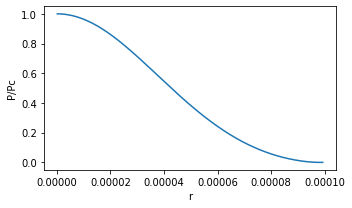

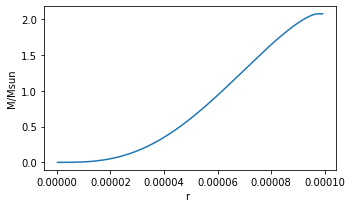

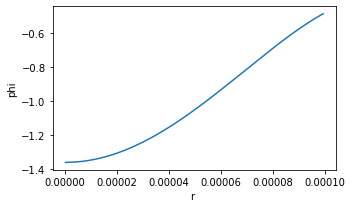

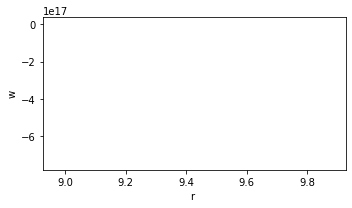

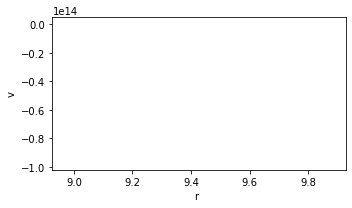

In [15]:
mpl.rcParams['figure.figsize'] = (5, 3)
r_arr = r_arr/km2cm


plt.figure()
plt.plot(r_arr, p/p_c)
plt.xlabel("r")
plt.ylabel("P/Pc")

plt.figure()
plt.plot(r_arr, m/msun)
plt.xlabel("r ")
plt.ylabel("M/Msun")
plt.show()

plt.figure()
plt.plot(r_arr, phi)
plt.xlabel("r ")
plt.ylabel("phi")
plt.show()

plt.figure()
plt.plot(r_arr, w)
plt.xlabel("r ")
plt.ylabel("w")
plt.xlim(r_R/km2cm-1, r_R/km2cm-0)
plt.show()

plt.figure()
plt.plot(r_arr, v)
plt.xlabel("r ")
plt.ylabel("v")
plt.xlim(r_R/km2cm-1, r_R/km2cm-0)
plt.show()

The fact that v, w are oscillating so much implies that a change in sign of W could easily have huge impacts on the value of the boundary term. Should w be smooth? V, W have approximately the same oscillation rates hence do we expect them to cancel out each other. 

In [16]:
# If w, v at R have opposite sign, print 1, else print -1
print(-np.sign(v_R)*np.sign(w_R))

-1.0


In [17]:
# F MODE IS 2PI * OMEGA 